# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

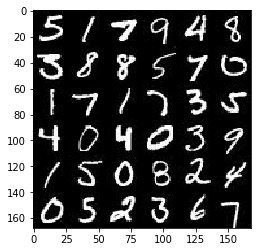

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

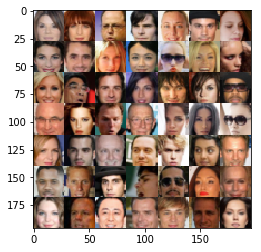

In [3]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learn')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(layer1 * alpha, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(layer2 * alpha, layer2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(layer3 * alpha, layer3)
        
        flattened = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

        return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=reuse):
        n_units = 7*7*256

        layer1 = tf.layers.dense(z, n_units, activation=None)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(layer1 * alpha, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2 * alpha, layer2)
        
        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)*0.9))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return (discriminator_loss, generator_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 
    _, width, height, num_channels = data_shape
    input_real, input_z, learn = model_inputs(width, height, num_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learn, beta1)   
    
    steps = 0
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale from (-0.5, 0.5) to (-1, 1). Thanks Udacity forums!
                batch_images *= 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {
                    input_real: batch_images, 
                    input_z: batch_z, 
                    learn: learning_rate
                })
                sess.run(g_opt, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z, 
                    learn: learning_rate
                })
                    
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                learn: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                learn: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {} ->".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, num_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 -> Discriminator Loss: 0.6420... Generator Loss: 1.5529
Epoch 1/2... Step 20 -> Discriminator Loss: 0.6689... Generator Loss: 1.8055
Epoch 1/2... Step 30 -> Discriminator Loss: 0.6615... Generator Loss: 1.6081
Epoch 1/2... Step 40 -> Discriminator Loss: 1.7065... Generator Loss: 0.4670
Epoch 1/2... Step 50 -> Discriminator Loss: 0.6166... Generator Loss: 1.8238
Epoch 1/2... Step 60 -> Discriminator Loss: 0.8756... Generator Loss: 1.0965
Epoch 1/2... Step 70 -> Discriminator Loss: 0.6526... Generator Loss: 2.2946
Epoch 1/2... Step 80 -> Discriminator Loss: 0.5993... Generator Loss: 2.1862
Epoch 1/2... Step 90 -> Discriminator Loss: 0.7029... Generator Loss: 2.6245
Epoch 1/2... Step 100 -> Discriminator Loss: 1.2166... Generator Loss: 0.7145


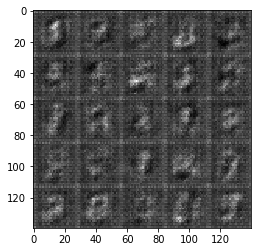

Epoch 1/2... Step 110 -> Discriminator Loss: 0.6283... Generator Loss: 1.8185
Epoch 1/2... Step 120 -> Discriminator Loss: 0.6953... Generator Loss: 1.8671
Epoch 1/2... Step 130 -> Discriminator Loss: 0.6990... Generator Loss: 2.3478
Epoch 1/2... Step 140 -> Discriminator Loss: 0.7132... Generator Loss: 1.3777
Epoch 1/2... Step 150 -> Discriminator Loss: 0.6340... Generator Loss: 1.9954
Epoch 1/2... Step 160 -> Discriminator Loss: 0.7776... Generator Loss: 1.2400
Epoch 1/2... Step 170 -> Discriminator Loss: 0.9067... Generator Loss: 3.2356
Epoch 1/2... Step 180 -> Discriminator Loss: 0.6694... Generator Loss: 1.6611
Epoch 1/2... Step 190 -> Discriminator Loss: 0.6638... Generator Loss: 1.5025
Epoch 1/2... Step 200 -> Discriminator Loss: 0.9450... Generator Loss: 0.9497


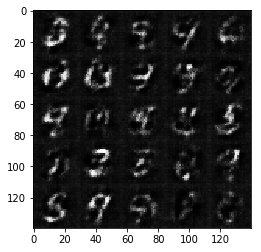

Epoch 1/2... Step 210 -> Discriminator Loss: 0.7462... Generator Loss: 1.3038
Epoch 1/2... Step 220 -> Discriminator Loss: 0.5523... Generator Loss: 2.2466
Epoch 1/2... Step 230 -> Discriminator Loss: 0.5659... Generator Loss: 2.3277
Epoch 1/2... Step 240 -> Discriminator Loss: 0.5734... Generator Loss: 2.2141
Epoch 1/2... Step 250 -> Discriminator Loss: 0.5951... Generator Loss: 1.8448
Epoch 1/2... Step 260 -> Discriminator Loss: 0.6341... Generator Loss: 1.6414
Epoch 1/2... Step 270 -> Discriminator Loss: 0.6707... Generator Loss: 1.5061
Epoch 1/2... Step 280 -> Discriminator Loss: 0.7296... Generator Loss: 1.2944
Epoch 1/2... Step 290 -> Discriminator Loss: 0.6792... Generator Loss: 1.4193
Epoch 1/2... Step 300 -> Discriminator Loss: 0.6607... Generator Loss: 1.6345


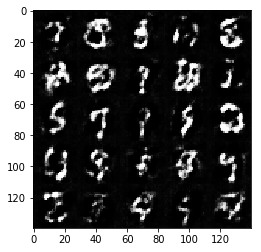

Epoch 1/2... Step 310 -> Discriminator Loss: 0.6124... Generator Loss: 1.9113
Epoch 1/2... Step 320 -> Discriminator Loss: 0.7293... Generator Loss: 1.3358
Epoch 1/2... Step 330 -> Discriminator Loss: 0.5626... Generator Loss: 2.7418
Epoch 1/2... Step 340 -> Discriminator Loss: 1.2509... Generator Loss: 0.7050
Epoch 1/2... Step 350 -> Discriminator Loss: 0.5491... Generator Loss: 1.9717
Epoch 1/2... Step 360 -> Discriminator Loss: 0.5344... Generator Loss: 2.1655
Epoch 1/2... Step 370 -> Discriminator Loss: 0.5269... Generator Loss: 2.5766
Epoch 1/2... Step 380 -> Discriminator Loss: 0.5644... Generator Loss: 2.0013
Epoch 1/2... Step 390 -> Discriminator Loss: 0.5902... Generator Loss: 2.1399
Epoch 1/2... Step 400 -> Discriminator Loss: 0.5431... Generator Loss: 2.1683


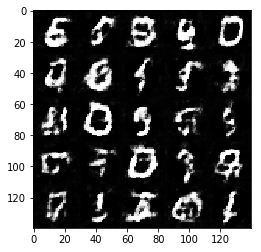

Epoch 1/2... Step 410 -> Discriminator Loss: 0.5924... Generator Loss: 1.9905
Epoch 1/2... Step 420 -> Discriminator Loss: 0.9394... Generator Loss: 1.0185
Epoch 1/2... Step 430 -> Discriminator Loss: 0.5964... Generator Loss: 1.7103
Epoch 1/2... Step 440 -> Discriminator Loss: 0.6705... Generator Loss: 2.1164
Epoch 1/2... Step 450 -> Discriminator Loss: 0.6012... Generator Loss: 1.7357
Epoch 1/2... Step 460 -> Discriminator Loss: 0.9787... Generator Loss: 0.9870
Epoch 1/2... Step 470 -> Discriminator Loss: 1.2873... Generator Loss: 0.6180
Epoch 1/2... Step 480 -> Discriminator Loss: 1.3273... Generator Loss: 0.7108
Epoch 1/2... Step 490 -> Discriminator Loss: 0.7176... Generator Loss: 1.4351
Epoch 1/2... Step 500 -> Discriminator Loss: 1.2826... Generator Loss: 0.6318


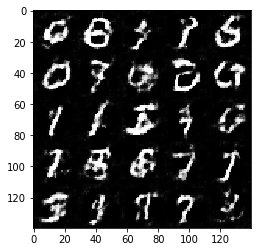

Epoch 1/2... Step 510 -> Discriminator Loss: 0.6433... Generator Loss: 2.0389
Epoch 1/2... Step 520 -> Discriminator Loss: 0.7277... Generator Loss: 1.3132
Epoch 1/2... Step 530 -> Discriminator Loss: 1.2372... Generator Loss: 0.6778
Epoch 1/2... Step 540 -> Discriminator Loss: 0.8282... Generator Loss: 1.2381
Epoch 1/2... Step 550 -> Discriminator Loss: 0.5935... Generator Loss: 2.0364
Epoch 1/2... Step 560 -> Discriminator Loss: 0.7794... Generator Loss: 1.3188
Epoch 1/2... Step 570 -> Discriminator Loss: 0.8835... Generator Loss: 2.8367
Epoch 1/2... Step 580 -> Discriminator Loss: 0.6069... Generator Loss: 1.9435
Epoch 1/2... Step 590 -> Discriminator Loss: 0.7233... Generator Loss: 1.5286
Epoch 1/2... Step 600 -> Discriminator Loss: 0.7127... Generator Loss: 1.4210


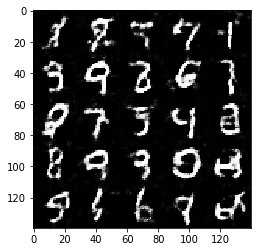

Epoch 1/2... Step 610 -> Discriminator Loss: 0.6269... Generator Loss: 1.7884
Epoch 1/2... Step 620 -> Discriminator Loss: 0.6641... Generator Loss: 1.7066
Epoch 1/2... Step 630 -> Discriminator Loss: 0.7659... Generator Loss: 1.4276
Epoch 1/2... Step 640 -> Discriminator Loss: 0.6116... Generator Loss: 2.0695
Epoch 1/2... Step 650 -> Discriminator Loss: 0.6846... Generator Loss: 1.7132
Epoch 1/2... Step 660 -> Discriminator Loss: 0.9649... Generator Loss: 0.8744
Epoch 1/2... Step 670 -> Discriminator Loss: 0.7162... Generator Loss: 1.3903
Epoch 1/2... Step 680 -> Discriminator Loss: 1.4618... Generator Loss: 3.8562
Epoch 1/2... Step 690 -> Discriminator Loss: 0.6835... Generator Loss: 2.2107
Epoch 1/2... Step 700 -> Discriminator Loss: 0.7984... Generator Loss: 2.0249


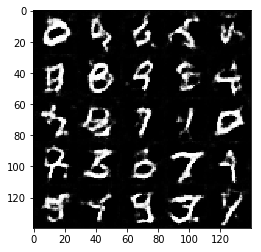

Epoch 1/2... Step 710 -> Discriminator Loss: 0.7447... Generator Loss: 1.3175
Epoch 1/2... Step 720 -> Discriminator Loss: 0.7511... Generator Loss: 1.2596
Epoch 1/2... Step 730 -> Discriminator Loss: 0.5420... Generator Loss: 2.1751
Epoch 1/2... Step 740 -> Discriminator Loss: 0.8408... Generator Loss: 1.1788
Epoch 1/2... Step 750 -> Discriminator Loss: 0.6831... Generator Loss: 2.4682
Epoch 1/2... Step 760 -> Discriminator Loss: 0.6406... Generator Loss: 2.3282
Epoch 1/2... Step 770 -> Discriminator Loss: 0.6229... Generator Loss: 1.8197
Epoch 1/2... Step 780 -> Discriminator Loss: 0.7474... Generator Loss: 1.2761
Epoch 1/2... Step 790 -> Discriminator Loss: 0.6403... Generator Loss: 1.5930
Epoch 1/2... Step 800 -> Discriminator Loss: 0.7738... Generator Loss: 1.3207


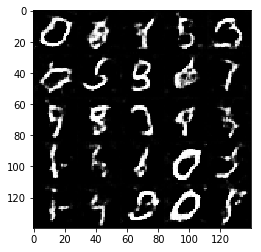

Epoch 1/2... Step 810 -> Discriminator Loss: 0.7072... Generator Loss: 1.3938
Epoch 1/2... Step 820 -> Discriminator Loss: 0.6657... Generator Loss: 1.5342
Epoch 1/2... Step 830 -> Discriminator Loss: 0.9404... Generator Loss: 0.9602
Epoch 1/2... Step 840 -> Discriminator Loss: 0.8041... Generator Loss: 1.1030
Epoch 1/2... Step 850 -> Discriminator Loss: 0.9191... Generator Loss: 2.4745
Epoch 1/2... Step 860 -> Discriminator Loss: 0.6629... Generator Loss: 1.5425
Epoch 1/2... Step 870 -> Discriminator Loss: 0.7843... Generator Loss: 1.2708
Epoch 1/2... Step 880 -> Discriminator Loss: 1.1741... Generator Loss: 0.8790
Epoch 1/2... Step 890 -> Discriminator Loss: 0.7533... Generator Loss: 1.3937
Epoch 1/2... Step 900 -> Discriminator Loss: 0.6426... Generator Loss: 1.7466


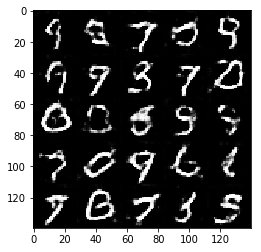

Epoch 1/2... Step 910 -> Discriminator Loss: 0.5990... Generator Loss: 1.7537
Epoch 1/2... Step 920 -> Discriminator Loss: 0.8294... Generator Loss: 1.0944
Epoch 1/2... Step 930 -> Discriminator Loss: 0.6044... Generator Loss: 1.7820
Epoch 2/2... Step 940 -> Discriminator Loss: 0.8602... Generator Loss: 1.1251
Epoch 2/2... Step 950 -> Discriminator Loss: 0.7769... Generator Loss: 1.2872
Epoch 2/2... Step 960 -> Discriminator Loss: 0.6123... Generator Loss: 1.7532
Epoch 2/2... Step 970 -> Discriminator Loss: 0.8715... Generator Loss: 1.1180
Epoch 2/2... Step 980 -> Discriminator Loss: 0.6050... Generator Loss: 1.9581
Epoch 2/2... Step 990 -> Discriminator Loss: 0.5658... Generator Loss: 2.2902
Epoch 2/2... Step 1000 -> Discriminator Loss: 0.7681... Generator Loss: 1.2309


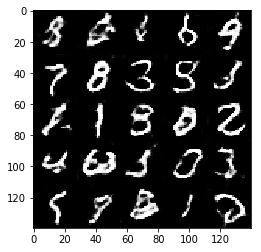

Epoch 2/2... Step 1010 -> Discriminator Loss: 0.6283... Generator Loss: 3.0608
Epoch 2/2... Step 1020 -> Discriminator Loss: 0.6520... Generator Loss: 1.6871
Epoch 2/2... Step 1030 -> Discriminator Loss: 0.5893... Generator Loss: 1.7062
Epoch 2/2... Step 1040 -> Discriminator Loss: 0.7523... Generator Loss: 1.3195
Epoch 2/2... Step 1050 -> Discriminator Loss: 0.6629... Generator Loss: 1.4913
Epoch 2/2... Step 1060 -> Discriminator Loss: 0.7940... Generator Loss: 1.1874
Epoch 2/2... Step 1070 -> Discriminator Loss: 0.6491... Generator Loss: 1.5026
Epoch 2/2... Step 1080 -> Discriminator Loss: 0.5699... Generator Loss: 2.3071
Epoch 2/2... Step 1090 -> Discriminator Loss: 0.5390... Generator Loss: 1.9447
Epoch 2/2... Step 1100 -> Discriminator Loss: 0.7906... Generator Loss: 1.1799


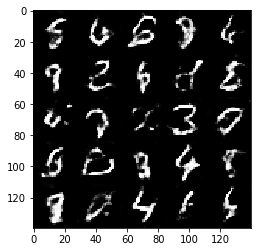

Epoch 2/2... Step 1110 -> Discriminator Loss: 0.7966... Generator Loss: 1.2340
Epoch 2/2... Step 1120 -> Discriminator Loss: 0.6197... Generator Loss: 1.6897
Epoch 2/2... Step 1130 -> Discriminator Loss: 0.6012... Generator Loss: 1.8329
Epoch 2/2... Step 1140 -> Discriminator Loss: 0.5441... Generator Loss: 2.0047
Epoch 2/2... Step 1150 -> Discriminator Loss: 0.8555... Generator Loss: 1.1073
Epoch 2/2... Step 1160 -> Discriminator Loss: 9.9638... Generator Loss: 0.0004
Epoch 2/2... Step 1170 -> Discriminator Loss: 0.7423... Generator Loss: 1.3992
Epoch 2/2... Step 1180 -> Discriminator Loss: 0.6245... Generator Loss: 1.7633
Epoch 2/2... Step 1190 -> Discriminator Loss: 0.6723... Generator Loss: 1.5237
Epoch 2/2... Step 1200 -> Discriminator Loss: 0.6589... Generator Loss: 1.5055


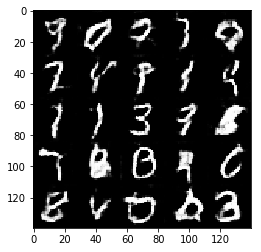

Epoch 2/2... Step 1210 -> Discriminator Loss: 0.7047... Generator Loss: 1.4144
Epoch 2/2... Step 1220 -> Discriminator Loss: 0.7388... Generator Loss: 1.3050
Epoch 2/2... Step 1230 -> Discriminator Loss: 0.7731... Generator Loss: 1.2063
Epoch 2/2... Step 1240 -> Discriminator Loss: 0.5712... Generator Loss: 1.8193
Epoch 2/2... Step 1250 -> Discriminator Loss: 0.6169... Generator Loss: 1.5974
Epoch 2/2... Step 1260 -> Discriminator Loss: 0.5767... Generator Loss: 1.8363
Epoch 2/2... Step 1270 -> Discriminator Loss: 1.1860... Generator Loss: 0.6681
Epoch 2/2... Step 1280 -> Discriminator Loss: 0.8103... Generator Loss: 1.1458
Epoch 2/2... Step 1290 -> Discriminator Loss: 0.8483... Generator Loss: 1.0400
Epoch 2/2... Step 1300 -> Discriminator Loss: 0.6791... Generator Loss: 1.4002


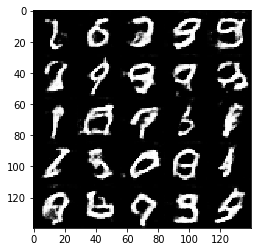

Epoch 2/2... Step 1310 -> Discriminator Loss: 1.2327... Generator Loss: 0.6409
Epoch 2/2... Step 1320 -> Discriminator Loss: 0.6346... Generator Loss: 1.6055
Epoch 2/2... Step 1330 -> Discriminator Loss: 0.6333... Generator Loss: 1.6719
Epoch 2/2... Step 1340 -> Discriminator Loss: 0.5614... Generator Loss: 1.8592
Epoch 2/2... Step 1350 -> Discriminator Loss: 0.5667... Generator Loss: 1.8755
Epoch 2/2... Step 1360 -> Discriminator Loss: 0.8372... Generator Loss: 2.4693
Epoch 2/2... Step 1370 -> Discriminator Loss: 0.7517... Generator Loss: 1.6534
Epoch 2/2... Step 1380 -> Discriminator Loss: 0.7597... Generator Loss: 1.1961
Epoch 2/2... Step 1390 -> Discriminator Loss: 0.5667... Generator Loss: 1.9191
Epoch 2/2... Step 1400 -> Discriminator Loss: 0.7433... Generator Loss: 1.2593


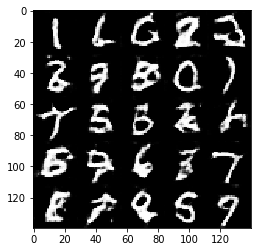

Epoch 2/2... Step 1410 -> Discriminator Loss: 1.1090... Generator Loss: 0.7466
Epoch 2/2... Step 1420 -> Discriminator Loss: 0.7741... Generator Loss: 1.1997
Epoch 2/2... Step 1430 -> Discriminator Loss: 0.8150... Generator Loss: 1.1394
Epoch 2/2... Step 1440 -> Discriminator Loss: 0.9788... Generator Loss: 0.9322
Epoch 2/2... Step 1450 -> Discriminator Loss: 0.6496... Generator Loss: 1.6711
Epoch 2/2... Step 1460 -> Discriminator Loss: 0.5645... Generator Loss: 1.8710
Epoch 2/2... Step 1470 -> Discriminator Loss: 1.0706... Generator Loss: 0.8127
Epoch 2/2... Step 1480 -> Discriminator Loss: 0.6876... Generator Loss: 1.3808
Epoch 2/2... Step 1490 -> Discriminator Loss: 0.6744... Generator Loss: 1.4403
Epoch 2/2... Step 1500 -> Discriminator Loss: 1.5119... Generator Loss: 0.4818


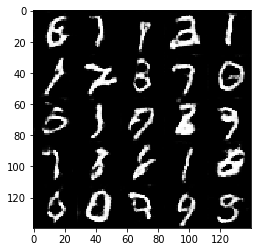

Epoch 2/2... Step 1510 -> Discriminator Loss: 0.5049... Generator Loss: 2.2517
Epoch 2/2... Step 1520 -> Discriminator Loss: 0.7603... Generator Loss: 1.3217
Epoch 2/2... Step 1530 -> Discriminator Loss: 0.4548... Generator Loss: 2.6976
Epoch 2/2... Step 1540 -> Discriminator Loss: 0.5794... Generator Loss: 1.8541
Epoch 2/2... Step 1550 -> Discriminator Loss: 0.7978... Generator Loss: 1.2032
Epoch 2/2... Step 1560 -> Discriminator Loss: 0.6966... Generator Loss: 1.3884
Epoch 2/2... Step 1570 -> Discriminator Loss: 0.9964... Generator Loss: 0.8737
Epoch 2/2... Step 1580 -> Discriminator Loss: 0.5596... Generator Loss: 1.8680
Epoch 2/2... Step 1590 -> Discriminator Loss: 0.9187... Generator Loss: 3.4670
Epoch 2/2... Step 1600 -> Discriminator Loss: 0.6458... Generator Loss: 1.9958


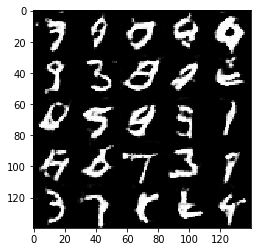

Epoch 2/2... Step 1610 -> Discriminator Loss: 0.6062... Generator Loss: 1.7503
Epoch 2/2... Step 1620 -> Discriminator Loss: 0.5469... Generator Loss: 1.9128
Epoch 2/2... Step 1630 -> Discriminator Loss: 0.6120... Generator Loss: 1.6656
Epoch 2/2... Step 1640 -> Discriminator Loss: 0.4952... Generator Loss: 2.3733
Epoch 2/2... Step 1650 -> Discriminator Loss: 0.6749... Generator Loss: 1.4667
Epoch 2/2... Step 1660 -> Discriminator Loss: 4.6445... Generator Loss: 0.0369
Epoch 2/2... Step 1670 -> Discriminator Loss: 0.6552... Generator Loss: 1.5618
Epoch 2/2... Step 1680 -> Discriminator Loss: 0.5738... Generator Loss: 1.8634
Epoch 2/2... Step 1690 -> Discriminator Loss: 0.6074... Generator Loss: 1.7122
Epoch 2/2... Step 1700 -> Discriminator Loss: 0.4982... Generator Loss: 2.4560


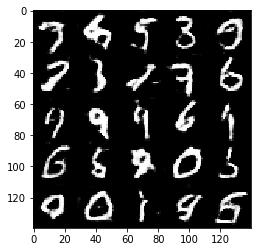

Epoch 2/2... Step 1710 -> Discriminator Loss: 0.6052... Generator Loss: 1.8031
Epoch 2/2... Step 1720 -> Discriminator Loss: 0.6244... Generator Loss: 1.6048
Epoch 2/2... Step 1730 -> Discriminator Loss: 0.5572... Generator Loss: 1.9211
Epoch 2/2... Step 1740 -> Discriminator Loss: 0.7390... Generator Loss: 1.2607
Epoch 2/2... Step 1750 -> Discriminator Loss: 0.5946... Generator Loss: 1.7150
Epoch 2/2... Step 1760 -> Discriminator Loss: 0.5186... Generator Loss: 2.1896
Epoch 2/2... Step 1770 -> Discriminator Loss: 0.8626... Generator Loss: 1.1363
Epoch 2/2... Step 1780 -> Discriminator Loss: 1.1081... Generator Loss: 0.7749
Epoch 2/2... Step 1790 -> Discriminator Loss: 0.8756... Generator Loss: 1.0763
Epoch 2/2... Step 1800 -> Discriminator Loss: 0.5672... Generator Loss: 1.7581


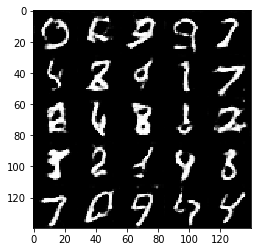

Epoch 2/2... Step 1810 -> Discriminator Loss: 1.7492... Generator Loss: 0.4305
Epoch 2/2... Step 1820 -> Discriminator Loss: 0.9661... Generator Loss: 1.2923
Epoch 2/2... Step 1830 -> Discriminator Loss: 0.7895... Generator Loss: 1.4264
Epoch 2/2... Step 1840 -> Discriminator Loss: 0.9094... Generator Loss: 1.0404
Epoch 2/2... Step 1850 -> Discriminator Loss: 0.9117... Generator Loss: 1.0863
Epoch 2/2... Step 1860 -> Discriminator Loss: 0.5433... Generator Loss: 2.3649
Epoch 2/2... Step 1870 -> Discriminator Loss: 0.6105... Generator Loss: 1.7195


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 -> Discriminator Loss: 0.4649... Generator Loss: 3.1723
Epoch 1/1... Step 20 -> Discriminator Loss: 0.8133... Generator Loss: 1.3511
Epoch 1/1... Step 30 -> Discriminator Loss: 0.8894... Generator Loss: 1.0661
Epoch 1/1... Step 40 -> Discriminator Loss: 0.7589... Generator Loss: 1.3526
Epoch 1/1... Step 50 -> Discriminator Loss: 1.7493... Generator Loss: 0.4395
Epoch 1/1... Step 60 -> Discriminator Loss: 0.8065... Generator Loss: 2.4538
Epoch 1/1... Step 70 -> Discriminator Loss: 1.5076... Generator Loss: 4.9804
Epoch 1/1... Step 80 -> Discriminator Loss: 1.1919... Generator Loss: 0.7012
Epoch 1/1... Step 90 -> Discriminator Loss: 1.3255... Generator Loss: 0.5821
Epoch 1/1... Step 100 -> Discriminator Loss: 0.6404... Generator Loss: 2.8833


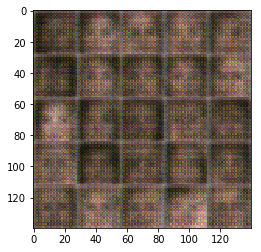

Epoch 1/1... Step 110 -> Discriminator Loss: 1.2108... Generator Loss: 0.6361
Epoch 1/1... Step 120 -> Discriminator Loss: 0.6190... Generator Loss: 1.8576
Epoch 1/1... Step 130 -> Discriminator Loss: 0.6309... Generator Loss: 1.6777
Epoch 1/1... Step 140 -> Discriminator Loss: 0.6511... Generator Loss: 1.8836
Epoch 1/1... Step 150 -> Discriminator Loss: 0.7222... Generator Loss: 2.8650
Epoch 1/1... Step 160 -> Discriminator Loss: 1.4538... Generator Loss: 4.5497
Epoch 1/1... Step 170 -> Discriminator Loss: 0.7372... Generator Loss: 1.9028
Epoch 1/1... Step 180 -> Discriminator Loss: 0.7648... Generator Loss: 2.3322
Epoch 1/1... Step 190 -> Discriminator Loss: 0.6449... Generator Loss: 2.5254
Epoch 1/1... Step 200 -> Discriminator Loss: 0.7271... Generator Loss: 1.8770


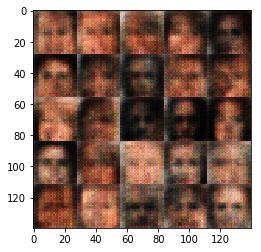

Epoch 1/1... Step 210 -> Discriminator Loss: 0.9329... Generator Loss: 0.9995
Epoch 1/1... Step 220 -> Discriminator Loss: 1.3167... Generator Loss: 0.6446
Epoch 1/1... Step 230 -> Discriminator Loss: 0.9163... Generator Loss: 1.1367
Epoch 1/1... Step 240 -> Discriminator Loss: 0.6511... Generator Loss: 2.0543
Epoch 1/1... Step 250 -> Discriminator Loss: 0.8473... Generator Loss: 1.1106
Epoch 1/1... Step 260 -> Discriminator Loss: 1.4952... Generator Loss: 4.2995
Epoch 1/1... Step 270 -> Discriminator Loss: 0.8498... Generator Loss: 1.1547
Epoch 1/1... Step 280 -> Discriminator Loss: 0.7046... Generator Loss: 1.5187
Epoch 1/1... Step 290 -> Discriminator Loss: 0.6953... Generator Loss: 1.6097
Epoch 1/1... Step 300 -> Discriminator Loss: 0.8053... Generator Loss: 1.4663


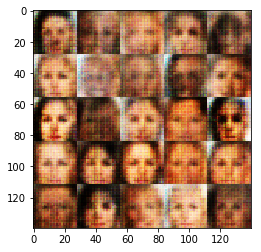

Epoch 1/1... Step 310 -> Discriminator Loss: 0.4953... Generator Loss: 2.5286
Epoch 1/1... Step 320 -> Discriminator Loss: 1.3195... Generator Loss: 0.5668
Epoch 1/1... Step 330 -> Discriminator Loss: 1.4658... Generator Loss: 0.5470
Epoch 1/1... Step 340 -> Discriminator Loss: 0.7384... Generator Loss: 1.4609
Epoch 1/1... Step 350 -> Discriminator Loss: 1.3869... Generator Loss: 0.5190
Epoch 1/1... Step 360 -> Discriminator Loss: 0.7024... Generator Loss: 1.5239
Epoch 1/1... Step 370 -> Discriminator Loss: 0.8926... Generator Loss: 1.1029
Epoch 1/1... Step 380 -> Discriminator Loss: 1.2326... Generator Loss: 2.9921
Epoch 1/1... Step 390 -> Discriminator Loss: 0.7840... Generator Loss: 1.4487
Epoch 1/1... Step 400 -> Discriminator Loss: 1.8765... Generator Loss: 0.3260


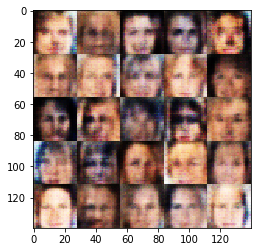

Epoch 1/1... Step 410 -> Discriminator Loss: 0.7936... Generator Loss: 1.3845
Epoch 1/1... Step 420 -> Discriminator Loss: 0.7771... Generator Loss: 1.2368
Epoch 1/1... Step 430 -> Discriminator Loss: 0.8610... Generator Loss: 1.1253
Epoch 1/1... Step 440 -> Discriminator Loss: 0.7394... Generator Loss: 1.8608
Epoch 1/1... Step 450 -> Discriminator Loss: 0.8025... Generator Loss: 1.3088
Epoch 1/1... Step 460 -> Discriminator Loss: 2.5426... Generator Loss: 4.5701
Epoch 1/1... Step 470 -> Discriminator Loss: 0.8477... Generator Loss: 1.3395
Epoch 1/1... Step 480 -> Discriminator Loss: 0.7750... Generator Loss: 1.5428
Epoch 1/1... Step 490 -> Discriminator Loss: 0.8796... Generator Loss: 1.2458
Epoch 1/1... Step 500 -> Discriminator Loss: 1.0108... Generator Loss: 2.9379


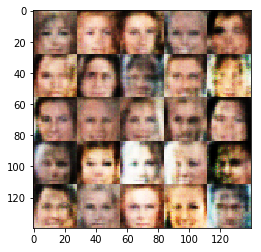

Epoch 1/1... Step 510 -> Discriminator Loss: 1.1131... Generator Loss: 0.7398
Epoch 1/1... Step 520 -> Discriminator Loss: 0.8348... Generator Loss: 1.2216
Epoch 1/1... Step 530 -> Discriminator Loss: 0.8106... Generator Loss: 2.5701
Epoch 1/1... Step 540 -> Discriminator Loss: 0.8112... Generator Loss: 1.6315
Epoch 1/1... Step 550 -> Discriminator Loss: 0.7939... Generator Loss: 1.4203
Epoch 1/1... Step 560 -> Discriminator Loss: 0.8708... Generator Loss: 1.1131
Epoch 1/1... Step 570 -> Discriminator Loss: 0.7853... Generator Loss: 1.4857
Epoch 1/1... Step 580 -> Discriminator Loss: 0.7620... Generator Loss: 1.6608
Epoch 1/1... Step 590 -> Discriminator Loss: 1.6576... Generator Loss: 0.3669
Epoch 1/1... Step 600 -> Discriminator Loss: 0.7785... Generator Loss: 1.4050


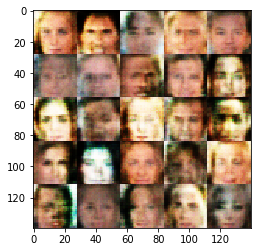

Epoch 1/1... Step 610 -> Discriminator Loss: 1.3093... Generator Loss: 0.5888
Epoch 1/1... Step 620 -> Discriminator Loss: 0.7565... Generator Loss: 1.4170
Epoch 1/1... Step 630 -> Discriminator Loss: 1.1556... Generator Loss: 0.7300
Epoch 1/1... Step 640 -> Discriminator Loss: 0.8703... Generator Loss: 1.1756
Epoch 1/1... Step 650 -> Discriminator Loss: 0.8080... Generator Loss: 1.5838
Epoch 1/1... Step 660 -> Discriminator Loss: 0.9092... Generator Loss: 1.0025
Epoch 1/1... Step 670 -> Discriminator Loss: 0.7815... Generator Loss: 1.2110
Epoch 1/1... Step 680 -> Discriminator Loss: 0.9550... Generator Loss: 0.9196
Epoch 1/1... Step 690 -> Discriminator Loss: 1.0052... Generator Loss: 0.8302
Epoch 1/1... Step 700 -> Discriminator Loss: 0.7741... Generator Loss: 1.9170


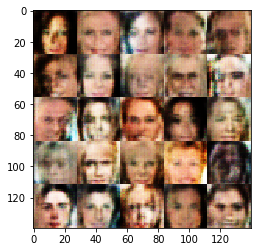

Epoch 1/1... Step 710 -> Discriminator Loss: 1.0568... Generator Loss: 0.8580
Epoch 1/1... Step 720 -> Discriminator Loss: 1.0451... Generator Loss: 0.8181
Epoch 1/1... Step 730 -> Discriminator Loss: 0.7152... Generator Loss: 1.7764
Epoch 1/1... Step 740 -> Discriminator Loss: 1.0774... Generator Loss: 0.7677
Epoch 1/1... Step 750 -> Discriminator Loss: 0.7896... Generator Loss: 1.1854
Epoch 1/1... Step 760 -> Discriminator Loss: 1.3996... Generator Loss: 0.5180
Epoch 1/1... Step 770 -> Discriminator Loss: 0.9863... Generator Loss: 0.9055
Epoch 1/1... Step 780 -> Discriminator Loss: 0.7392... Generator Loss: 2.3679
Epoch 1/1... Step 790 -> Discriminator Loss: 0.6474... Generator Loss: 1.7941
Epoch 1/1... Step 800 -> Discriminator Loss: 1.2206... Generator Loss: 0.6171


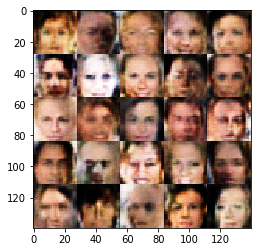

Epoch 1/1... Step 810 -> Discriminator Loss: 0.8057... Generator Loss: 1.3548
Epoch 1/1... Step 820 -> Discriminator Loss: 1.2988... Generator Loss: 0.5784
Epoch 1/1... Step 830 -> Discriminator Loss: 1.1143... Generator Loss: 0.7535
Epoch 1/1... Step 840 -> Discriminator Loss: 1.0490... Generator Loss: 0.8242
Epoch 1/1... Step 850 -> Discriminator Loss: 0.6086... Generator Loss: 2.2602
Epoch 1/1... Step 860 -> Discriminator Loss: 0.6896... Generator Loss: 2.7632
Epoch 1/1... Step 870 -> Discriminator Loss: 0.9388... Generator Loss: 0.9939
Epoch 1/1... Step 880 -> Discriminator Loss: 0.8969... Generator Loss: 1.0879
Epoch 1/1... Step 890 -> Discriminator Loss: 0.8991... Generator Loss: 1.1608
Epoch 1/1... Step 900 -> Discriminator Loss: 0.7221... Generator Loss: 1.7849


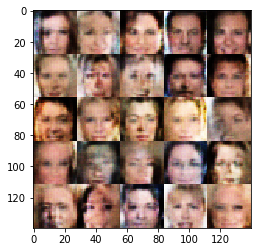

Epoch 1/1... Step 910 -> Discriminator Loss: 1.2815... Generator Loss: 1.4406
Epoch 1/1... Step 920 -> Discriminator Loss: 0.7104... Generator Loss: 1.4797
Epoch 1/1... Step 930 -> Discriminator Loss: 0.8863... Generator Loss: 1.9580
Epoch 1/1... Step 940 -> Discriminator Loss: 0.7306... Generator Loss: 1.3832
Epoch 1/1... Step 950 -> Discriminator Loss: 0.6121... Generator Loss: 1.8766
Epoch 1/1... Step 960 -> Discriminator Loss: 0.7992... Generator Loss: 1.2450
Epoch 1/1... Step 970 -> Discriminator Loss: 0.7056... Generator Loss: 1.3343
Epoch 1/1... Step 980 -> Discriminator Loss: 0.5194... Generator Loss: 2.4090
Epoch 1/1... Step 990 -> Discriminator Loss: 0.9774... Generator Loss: 0.9186
Epoch 1/1... Step 1000 -> Discriminator Loss: 1.0336... Generator Loss: 2.0792


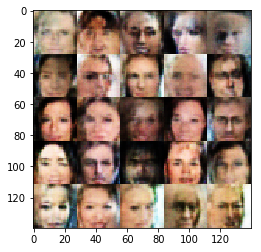

Epoch 1/1... Step 1010 -> Discriminator Loss: 0.9523... Generator Loss: 1.9768
Epoch 1/1... Step 1020 -> Discriminator Loss: 0.7704... Generator Loss: 1.4081
Epoch 1/1... Step 1030 -> Discriminator Loss: 0.5516... Generator Loss: 1.9888
Epoch 1/1... Step 1040 -> Discriminator Loss: 0.8435... Generator Loss: 1.1274
Epoch 1/1... Step 1050 -> Discriminator Loss: 0.6396... Generator Loss: 1.7483
Epoch 1/1... Step 1060 -> Discriminator Loss: 0.8927... Generator Loss: 1.0129
Epoch 1/1... Step 1070 -> Discriminator Loss: 0.7740... Generator Loss: 1.7854
Epoch 1/1... Step 1080 -> Discriminator Loss: 0.7526... Generator Loss: 1.4444
Epoch 1/1... Step 1090 -> Discriminator Loss: 0.7227... Generator Loss: 1.4447
Epoch 1/1... Step 1100 -> Discriminator Loss: 0.6525... Generator Loss: 1.5485


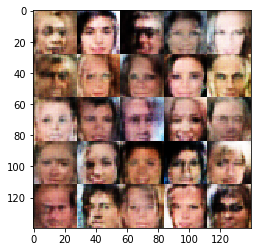

Epoch 1/1... Step 1110 -> Discriminator Loss: 0.6325... Generator Loss: 1.6498
Epoch 1/1... Step 1120 -> Discriminator Loss: 0.9503... Generator Loss: 1.3017
Epoch 1/1... Step 1130 -> Discriminator Loss: 0.9389... Generator Loss: 1.0905
Epoch 1/1... Step 1140 -> Discriminator Loss: 1.1049... Generator Loss: 2.8602
Epoch 1/1... Step 1150 -> Discriminator Loss: 0.7359... Generator Loss: 1.3707
Epoch 1/1... Step 1160 -> Discriminator Loss: 0.8575... Generator Loss: 1.0418
Epoch 1/1... Step 1170 -> Discriminator Loss: 1.1339... Generator Loss: 0.8318
Epoch 1/1... Step 1180 -> Discriminator Loss: 0.5167... Generator Loss: 2.5743
Epoch 1/1... Step 1190 -> Discriminator Loss: 0.7913... Generator Loss: 1.7476
Epoch 1/1... Step 1200 -> Discriminator Loss: 0.8251... Generator Loss: 2.0179


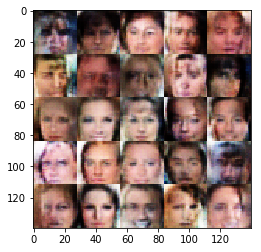

Epoch 1/1... Step 1210 -> Discriminator Loss: 0.9729... Generator Loss: 2.5008
Epoch 1/1... Step 1220 -> Discriminator Loss: 0.8928... Generator Loss: 1.1846
Epoch 1/1... Step 1230 -> Discriminator Loss: 1.0482... Generator Loss: 0.8547
Epoch 1/1... Step 1240 -> Discriminator Loss: 1.0088... Generator Loss: 0.8238
Epoch 1/1... Step 1250 -> Discriminator Loss: 1.0663... Generator Loss: 0.8498
Epoch 1/1... Step 1260 -> Discriminator Loss: 0.9830... Generator Loss: 0.8834
Epoch 1/1... Step 1270 -> Discriminator Loss: 0.5245... Generator Loss: 2.1990
Epoch 1/1... Step 1280 -> Discriminator Loss: 0.7357... Generator Loss: 1.7510
Epoch 1/1... Step 1290 -> Discriminator Loss: 1.1526... Generator Loss: 1.6190
Epoch 1/1... Step 1300 -> Discriminator Loss: 0.7393... Generator Loss: 1.4855


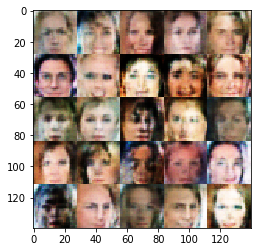

Epoch 1/1... Step 1310 -> Discriminator Loss: 0.7195... Generator Loss: 1.7572
Epoch 1/1... Step 1320 -> Discriminator Loss: 1.4351... Generator Loss: 0.4797
Epoch 1/1... Step 1330 -> Discriminator Loss: 0.8469... Generator Loss: 1.2663
Epoch 1/1... Step 1340 -> Discriminator Loss: 1.1570... Generator Loss: 1.4834
Epoch 1/1... Step 1350 -> Discriminator Loss: 0.6673... Generator Loss: 2.0975
Epoch 1/1... Step 1360 -> Discriminator Loss: 0.6935... Generator Loss: 1.5924
Epoch 1/1... Step 1370 -> Discriminator Loss: 0.8385... Generator Loss: 1.0873
Epoch 1/1... Step 1380 -> Discriminator Loss: 0.7891... Generator Loss: 1.3082
Epoch 1/1... Step 1390 -> Discriminator Loss: 1.6325... Generator Loss: 0.4000
Epoch 1/1... Step 1400 -> Discriminator Loss: 0.7427... Generator Loss: 1.5630


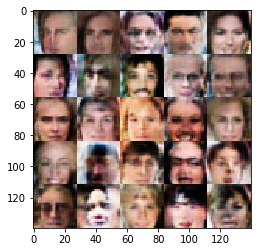

Epoch 1/1... Step 1410 -> Discriminator Loss: 0.9531... Generator Loss: 0.9700
Epoch 1/1... Step 1420 -> Discriminator Loss: 0.9743... Generator Loss: 1.0800
Epoch 1/1... Step 1430 -> Discriminator Loss: 0.5084... Generator Loss: 2.2834
Epoch 1/1... Step 1440 -> Discriminator Loss: 1.4068... Generator Loss: 0.4899
Epoch 1/1... Step 1450 -> Discriminator Loss: 1.2529... Generator Loss: 0.6082
Epoch 1/1... Step 1460 -> Discriminator Loss: 1.3118... Generator Loss: 0.5686
Epoch 1/1... Step 1470 -> Discriminator Loss: 0.9025... Generator Loss: 0.9624
Epoch 1/1... Step 1480 -> Discriminator Loss: 0.6498... Generator Loss: 2.0408
Epoch 1/1... Step 1490 -> Discriminator Loss: 0.6496... Generator Loss: 1.6669
Epoch 1/1... Step 1500 -> Discriminator Loss: 0.4890... Generator Loss: 2.7675


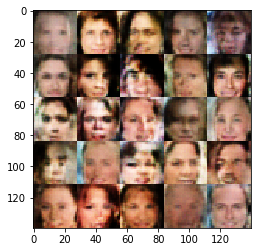

Epoch 1/1... Step 1510 -> Discriminator Loss: 0.7321... Generator Loss: 1.7874
Epoch 1/1... Step 1520 -> Discriminator Loss: 0.6676... Generator Loss: 1.6820
Epoch 1/1... Step 1530 -> Discriminator Loss: 0.5660... Generator Loss: 1.8635
Epoch 1/1... Step 1540 -> Discriminator Loss: 0.8077... Generator Loss: 1.1087
Epoch 1/1... Step 1550 -> Discriminator Loss: 0.6522... Generator Loss: 1.6499
Epoch 1/1... Step 1560 -> Discriminator Loss: 0.5653... Generator Loss: 1.8106
Epoch 1/1... Step 1570 -> Discriminator Loss: 0.5844... Generator Loss: 1.7810
Epoch 1/1... Step 1580 -> Discriminator Loss: 0.4666... Generator Loss: 3.3146
Epoch 1/1... Step 1590 -> Discriminator Loss: 0.4804... Generator Loss: 2.2925
Epoch 1/1... Step 1600 -> Discriminator Loss: 0.9761... Generator Loss: 2.7033


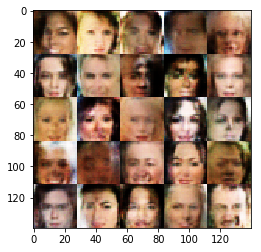

Epoch 1/1... Step 1610 -> Discriminator Loss: 0.8651... Generator Loss: 1.1756
Epoch 1/1... Step 1620 -> Discriminator Loss: 0.8276... Generator Loss: 1.3326
Epoch 1/1... Step 1630 -> Discriminator Loss: 0.8362... Generator Loss: 1.2886
Epoch 1/1... Step 1640 -> Discriminator Loss: 0.8648... Generator Loss: 1.8378
Epoch 1/1... Step 1650 -> Discriminator Loss: 0.6133... Generator Loss: 1.6840
Epoch 1/1... Step 1660 -> Discriminator Loss: 0.7448... Generator Loss: 1.5789
Epoch 1/1... Step 1670 -> Discriminator Loss: 0.5646... Generator Loss: 1.9100
Epoch 1/1... Step 1680 -> Discriminator Loss: 0.5427... Generator Loss: 2.1635
Epoch 1/1... Step 1690 -> Discriminator Loss: 0.5349... Generator Loss: 2.0222
Epoch 1/1... Step 1700 -> Discriminator Loss: 0.7058... Generator Loss: 1.3377


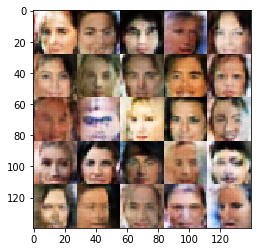

Epoch 1/1... Step 1710 -> Discriminator Loss: 1.2086... Generator Loss: 0.6336
Epoch 1/1... Step 1720 -> Discriminator Loss: 0.6913... Generator Loss: 1.4215
Epoch 1/1... Step 1730 -> Discriminator Loss: 0.4971... Generator Loss: 2.5544
Epoch 1/1... Step 1740 -> Discriminator Loss: 0.4415... Generator Loss: 2.7998
Epoch 1/1... Step 1750 -> Discriminator Loss: 0.5101... Generator Loss: 2.1275
Epoch 1/1... Step 1760 -> Discriminator Loss: 0.5306... Generator Loss: 2.0552
Epoch 1/1... Step 1770 -> Discriminator Loss: 1.2504... Generator Loss: 0.6040
Epoch 1/1... Step 1780 -> Discriminator Loss: 1.7041... Generator Loss: 0.3510
Epoch 1/1... Step 1790 -> Discriminator Loss: 0.9651... Generator Loss: 0.9625
Epoch 1/1... Step 1800 -> Discriminator Loss: 0.7451... Generator Loss: 1.3197


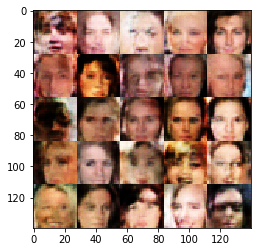

Epoch 1/1... Step 1810 -> Discriminator Loss: 0.7498... Generator Loss: 1.2955
Epoch 1/1... Step 1820 -> Discriminator Loss: 0.4701... Generator Loss: 2.5013
Epoch 1/1... Step 1830 -> Discriminator Loss: 0.5911... Generator Loss: 1.8037
Epoch 1/1... Step 1840 -> Discriminator Loss: 1.0560... Generator Loss: 1.3408
Epoch 1/1... Step 1850 -> Discriminator Loss: 0.7542... Generator Loss: 1.4830
Epoch 1/1... Step 1860 -> Discriminator Loss: 0.5060... Generator Loss: 2.4547
Epoch 1/1... Step 1870 -> Discriminator Loss: 0.4954... Generator Loss: 2.2208
Epoch 1/1... Step 1880 -> Discriminator Loss: 0.5472... Generator Loss: 1.9573
Epoch 1/1... Step 1890 -> Discriminator Loss: 0.4383... Generator Loss: 4.1001
Epoch 1/1... Step 1900 -> Discriminator Loss: 0.4162... Generator Loss: 3.5681


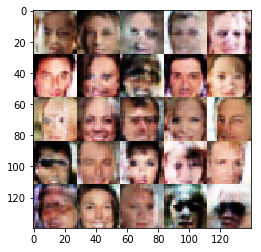

Epoch 1/1... Step 1910 -> Discriminator Loss: 0.4695... Generator Loss: 2.9528
Epoch 1/1... Step 1920 -> Discriminator Loss: 0.4853... Generator Loss: 2.6653
Epoch 1/1... Step 1930 -> Discriminator Loss: 0.7730... Generator Loss: 2.7606
Epoch 1/1... Step 1940 -> Discriminator Loss: 0.4839... Generator Loss: 2.6294
Epoch 1/1... Step 1950 -> Discriminator Loss: 1.0185... Generator Loss: 0.8541
Epoch 1/1... Step 1960 -> Discriminator Loss: 0.8068... Generator Loss: 2.3796
Epoch 1/1... Step 1970 -> Discriminator Loss: 1.0822... Generator Loss: 0.8997
Epoch 1/1... Step 1980 -> Discriminator Loss: 0.5263... Generator Loss: 2.6420
Epoch 1/1... Step 1990 -> Discriminator Loss: 1.3220... Generator Loss: 4.7346
Epoch 1/1... Step 2000 -> Discriminator Loss: 1.4604... Generator Loss: 0.5262


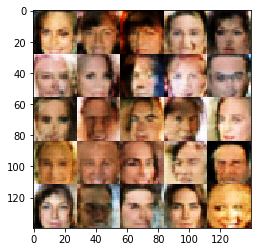

Epoch 1/1... Step 2010 -> Discriminator Loss: 0.7859... Generator Loss: 1.1791
Epoch 1/1... Step 2020 -> Discriminator Loss: 1.3335... Generator Loss: 0.5733
Epoch 1/1... Step 2030 -> Discriminator Loss: 0.4345... Generator Loss: 2.9093
Epoch 1/1... Step 2040 -> Discriminator Loss: 2.1901... Generator Loss: 3.8714
Epoch 1/1... Step 2050 -> Discriminator Loss: 0.9518... Generator Loss: 0.9131
Epoch 1/1... Step 2060 -> Discriminator Loss: 0.5833... Generator Loss: 2.0019
Epoch 1/1... Step 2070 -> Discriminator Loss: 0.4168... Generator Loss: 2.9575
Epoch 1/1... Step 2080 -> Discriminator Loss: 0.6150... Generator Loss: 1.6538
Epoch 1/1... Step 2090 -> Discriminator Loss: 0.6541... Generator Loss: 1.4860
Epoch 1/1... Step 2100 -> Discriminator Loss: 0.6258... Generator Loss: 1.6364


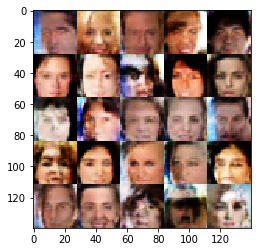

Epoch 1/1... Step 2110 -> Discriminator Loss: 1.9077... Generator Loss: 0.3521
Epoch 1/1... Step 2120 -> Discriminator Loss: 0.8187... Generator Loss: 1.1910
Epoch 1/1... Step 2130 -> Discriminator Loss: 1.1492... Generator Loss: 0.7197
Epoch 1/1... Step 2140 -> Discriminator Loss: 0.6798... Generator Loss: 1.4870
Epoch 1/1... Step 2150 -> Discriminator Loss: 0.4466... Generator Loss: 2.8074
Epoch 1/1... Step 2160 -> Discriminator Loss: 0.5236... Generator Loss: 2.9561
Epoch 1/1... Step 2170 -> Discriminator Loss: 0.4185... Generator Loss: 2.9775
Epoch 1/1... Step 2180 -> Discriminator Loss: 0.4040... Generator Loss: 3.6499
Epoch 1/1... Step 2190 -> Discriminator Loss: 0.4056... Generator Loss: 3.4571
Epoch 1/1... Step 2200 -> Discriminator Loss: 0.4401... Generator Loss: 2.6850


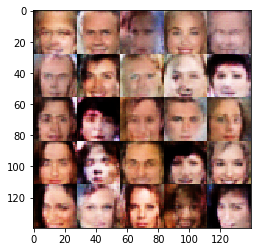

Epoch 1/1... Step 2210 -> Discriminator Loss: 0.8743... Generator Loss: 10.4521
Epoch 1/1... Step 2220 -> Discriminator Loss: 2.1939... Generator Loss: 0.2639
Epoch 1/1... Step 2230 -> Discriminator Loss: 0.7702... Generator Loss: 1.2189
Epoch 1/1... Step 2240 -> Discriminator Loss: 0.6857... Generator Loss: 4.3468
Epoch 1/1... Step 2250 -> Discriminator Loss: 0.5001... Generator Loss: 2.2112
Epoch 1/1... Step 2260 -> Discriminator Loss: 0.6360... Generator Loss: 4.9280
Epoch 1/1... Step 2270 -> Discriminator Loss: 0.6146... Generator Loss: 1.8435
Epoch 1/1... Step 2280 -> Discriminator Loss: 0.4109... Generator Loss: 3.3137
Epoch 1/1... Step 2290 -> Discriminator Loss: 0.4000... Generator Loss: 3.0274
Epoch 1/1... Step 2300 -> Discriminator Loss: 2.4537... Generator Loss: 0.1743


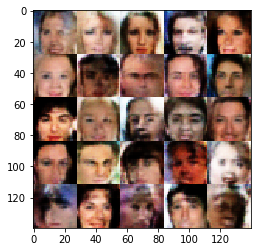

Epoch 1/1... Step 2310 -> Discriminator Loss: 0.8338... Generator Loss: 1.1104
Epoch 1/1... Step 2320 -> Discriminator Loss: 0.4855... Generator Loss: 5.3790
Epoch 1/1... Step 2330 -> Discriminator Loss: 0.4543... Generator Loss: 2.5077
Epoch 1/1... Step 2340 -> Discriminator Loss: 0.4917... Generator Loss: 2.3823
Epoch 1/1... Step 2350 -> Discriminator Loss: 0.6939... Generator Loss: 1.3887
Epoch 1/1... Step 2360 -> Discriminator Loss: 0.6266... Generator Loss: 1.9478
Epoch 1/1... Step 2370 -> Discriminator Loss: 0.6106... Generator Loss: 1.6606
Epoch 1/1... Step 2380 -> Discriminator Loss: 0.8120... Generator Loss: 1.1640
Epoch 1/1... Step 2390 -> Discriminator Loss: 1.7075... Generator Loss: 0.3955
Epoch 1/1... Step 2400 -> Discriminator Loss: 0.7192... Generator Loss: 1.7866


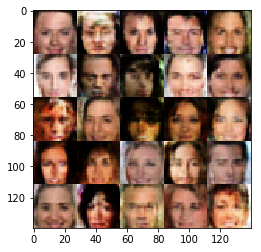

Epoch 1/1... Step 2410 -> Discriminator Loss: 0.6871... Generator Loss: 1.7951
Epoch 1/1... Step 2420 -> Discriminator Loss: 0.6995... Generator Loss: 1.3879
Epoch 1/1... Step 2430 -> Discriminator Loss: 0.8024... Generator Loss: 1.1910
Epoch 1/1... Step 2440 -> Discriminator Loss: 0.8938... Generator Loss: 1.0198
Epoch 1/1... Step 2450 -> Discriminator Loss: 1.2701... Generator Loss: 0.6602
Epoch 1/1... Step 2460 -> Discriminator Loss: 1.2404... Generator Loss: 0.6293
Epoch 1/1... Step 2470 -> Discriminator Loss: 0.9608... Generator Loss: 1.0077
Epoch 1/1... Step 2480 -> Discriminator Loss: 0.9452... Generator Loss: 0.9738
Epoch 1/1... Step 2490 -> Discriminator Loss: 0.3598... Generator Loss: 4.4737
Epoch 1/1... Step 2500 -> Discriminator Loss: 0.5247... Generator Loss: 2.1270


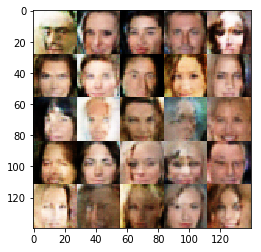

Epoch 1/1... Step 2510 -> Discriminator Loss: 0.5834... Generator Loss: 1.7509
Epoch 1/1... Step 2520 -> Discriminator Loss: 0.4477... Generator Loss: 2.6629
Epoch 1/1... Step 2530 -> Discriminator Loss: 0.3894... Generator Loss: 3.7998
Epoch 1/1... Step 2540 -> Discriminator Loss: 0.7241... Generator Loss: 2.2128
Epoch 1/1... Step 2550 -> Discriminator Loss: 0.5272... Generator Loss: 2.4856
Epoch 1/1... Step 2560 -> Discriminator Loss: 0.4332... Generator Loss: 2.6300
Epoch 1/1... Step 2570 -> Discriminator Loss: 0.5981... Generator Loss: 2.3336
Epoch 1/1... Step 2580 -> Discriminator Loss: 0.6879... Generator Loss: 1.4270
Epoch 1/1... Step 2590 -> Discriminator Loss: 0.4450... Generator Loss: 2.6394
Epoch 1/1... Step 2600 -> Discriminator Loss: 0.4392... Generator Loss: 2.9915


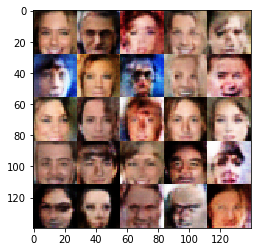

Epoch 1/1... Step 2610 -> Discriminator Loss: 0.4142... Generator Loss: 3.2790
Epoch 1/1... Step 2620 -> Discriminator Loss: 0.4452... Generator Loss: 2.8195
Epoch 1/1... Step 2630 -> Discriminator Loss: 0.5928... Generator Loss: 5.5763
Epoch 1/1... Step 2640 -> Discriminator Loss: 0.5877... Generator Loss: 2.1354
Epoch 1/1... Step 2650 -> Discriminator Loss: 0.8734... Generator Loss: 1.4193
Epoch 1/1... Step 2660 -> Discriminator Loss: 1.3360... Generator Loss: 0.5773
Epoch 1/1... Step 2670 -> Discriminator Loss: 0.4902... Generator Loss: 2.2284
Epoch 1/1... Step 2680 -> Discriminator Loss: 0.7520... Generator Loss: 6.9337
Epoch 1/1... Step 2690 -> Discriminator Loss: 0.5156... Generator Loss: 2.0504
Epoch 1/1... Step 2700 -> Discriminator Loss: 0.8563... Generator Loss: 3.8855


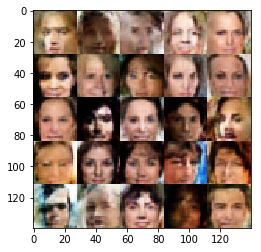

Epoch 1/1... Step 2710 -> Discriminator Loss: 0.6151... Generator Loss: 1.5909
Epoch 1/1... Step 2720 -> Discriminator Loss: 0.9748... Generator Loss: 4.1910
Epoch 1/1... Step 2730 -> Discriminator Loss: 0.5343... Generator Loss: 2.0216
Epoch 1/1... Step 2740 -> Discriminator Loss: 0.3648... Generator Loss: 4.5517
Epoch 1/1... Step 2750 -> Discriminator Loss: 0.6384... Generator Loss: 1.6004
Epoch 1/1... Step 2760 -> Discriminator Loss: 0.4030... Generator Loss: 3.4162
Epoch 1/1... Step 2770 -> Discriminator Loss: 0.5525... Generator Loss: 6.8477
Epoch 1/1... Step 2780 -> Discriminator Loss: 0.6040... Generator Loss: 1.6282
Epoch 1/1... Step 2790 -> Discriminator Loss: 0.5776... Generator Loss: 2.6871
Epoch 1/1... Step 2800 -> Discriminator Loss: 0.5932... Generator Loss: 4.5665


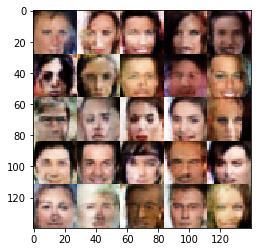

Epoch 1/1... Step 2810 -> Discriminator Loss: 0.4175... Generator Loss: 3.2759
Epoch 1/1... Step 2820 -> Discriminator Loss: 0.5411... Generator Loss: 3.7740
Epoch 1/1... Step 2830 -> Discriminator Loss: 0.5756... Generator Loss: 1.8509
Epoch 1/1... Step 2840 -> Discriminator Loss: 1.1079... Generator Loss: 0.8136
Epoch 1/1... Step 2850 -> Discriminator Loss: 0.9446... Generator Loss: 0.9455
Epoch 1/1... Step 2860 -> Discriminator Loss: 0.6702... Generator Loss: 1.9184
Epoch 1/1... Step 2870 -> Discriminator Loss: 1.2864... Generator Loss: 0.5779
Epoch 1/1... Step 2880 -> Discriminator Loss: 0.5866... Generator Loss: 1.6965
Epoch 1/1... Step 2890 -> Discriminator Loss: 0.4991... Generator Loss: 2.2027
Epoch 1/1... Step 2900 -> Discriminator Loss: 0.6666... Generator Loss: 1.4284


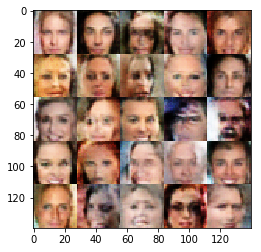

Epoch 1/1... Step 2910 -> Discriminator Loss: 1.0867... Generator Loss: 0.8469
Epoch 1/1... Step 2920 -> Discriminator Loss: 1.4401... Generator Loss: 0.5356
Epoch 1/1... Step 2930 -> Discriminator Loss: 0.5999... Generator Loss: 2.2845
Epoch 1/1... Step 2940 -> Discriminator Loss: 0.4259... Generator Loss: 2.7579
Epoch 1/1... Step 2950 -> Discriminator Loss: 0.4871... Generator Loss: 4.1873
Epoch 1/1... Step 2960 -> Discriminator Loss: 0.6943... Generator Loss: 1.8212
Epoch 1/1... Step 2970 -> Discriminator Loss: 0.4715... Generator Loss: 2.7299
Epoch 1/1... Step 2980 -> Discriminator Loss: 0.4176... Generator Loss: 4.9335
Epoch 1/1... Step 2990 -> Discriminator Loss: 0.4846... Generator Loss: 2.6868
Epoch 1/1... Step 3000 -> Discriminator Loss: 0.7949... Generator Loss: 1.2853


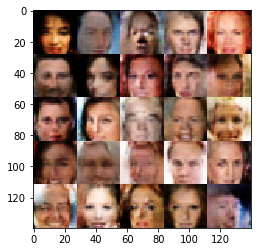

Epoch 1/1... Step 3010 -> Discriminator Loss: 0.9773... Generator Loss: 0.8344
Epoch 1/1... Step 3020 -> Discriminator Loss: 1.5713... Generator Loss: 0.4116
Epoch 1/1... Step 3030 -> Discriminator Loss: 0.4392... Generator Loss: 5.1288
Epoch 1/1... Step 3040 -> Discriminator Loss: 0.7076... Generator Loss: 8.0118
Epoch 1/1... Step 3050 -> Discriminator Loss: 0.4880... Generator Loss: 2.2320
Epoch 1/1... Step 3060 -> Discriminator Loss: 0.4153... Generator Loss: 3.3773
Epoch 1/1... Step 3070 -> Discriminator Loss: 0.3683... Generator Loss: 5.0596
Epoch 1/1... Step 3080 -> Discriminator Loss: 0.4965... Generator Loss: 3.3731
Epoch 1/1... Step 3090 -> Discriminator Loss: 0.6729... Generator Loss: 1.9276
Epoch 1/1... Step 3100 -> Discriminator Loss: 0.5861... Generator Loss: 1.7141


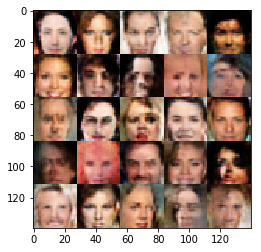

Epoch 1/1... Step 3110 -> Discriminator Loss: 0.4176... Generator Loss: 4.3601
Epoch 1/1... Step 3120 -> Discriminator Loss: 0.9448... Generator Loss: 0.9263
Epoch 1/1... Step 3130 -> Discriminator Loss: 0.4422... Generator Loss: 2.6672
Epoch 1/1... Step 3140 -> Discriminator Loss: 0.6224... Generator Loss: 1.5818
Epoch 1/1... Step 3150 -> Discriminator Loss: 0.4441... Generator Loss: 3.5211
Epoch 1/1... Step 3160 -> Discriminator Loss: 2.1650... Generator Loss: 0.2090


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.